Notebook exploring new features created from domain knowledge and PCA on the weather features. 

### Creation of features based on domain knowledge
We can create features based on our knowledge of the physical systems, i.e. the conditions under which the PV output varies in relation to the given features. Possible features to be engineered are as follows.

1. The adjusted power output, given by 
$$
P(T) = P_{STC} \times (1 - \alpha\times(T - T_{STC}))
$$
2. The dew point, given by 
$$
T_{dew} = T - \bigg(\frac{100 - H_{rel}}{5}\bigg),
$$
where $H_{rel}$ is the relative humidity.

3. A cloud cover score, being the sum of a visibility-based Cloud Cover score and a Cloud Ceiling-based Cloud Cover Score defined as follows.

- Visibility-based Cloud Cover Score:
    - Visibility > 10 km: Low cloud cover (score = 0)
    - Visibility 5-10 km: Moderate cloud cover (score = 1)
    - Visibility < 5 km: High cloud cover (score = 2)
- Cloud Ceiling-based Cloud Cover Score:
    - Cloud ceiling > 7500 m: Low cloud cover (score = 0)
    - Cloud ceiling 2500-7500 m: Moderate cloud cover (score = 1)
    - Cloud ceiling < 2500 m: High cloud cover (score = 2)

4. The temperature gradient, given by 
$$
\frac{\Delta T}{\Delta t} = \frac{T_{i} - T_{i-1}}{t_{i} - t_{i-1}},
$$
where $i$ indexes the time step.

Option 1 is just a linear transformation of the temperature and therefore won't add anything, while the temperature gradient is problematic since the EDA highlighted that we don't have consecutive readings consistently available for each site. On this basis, we won't pursue these options but the dew point and the cloud cover score can be derived directly from the data and treated similarly to the other features in the set. 

In [1]:
import sys
sys.path.append('../')

import src.utils.eda as eda
import src.utils.helper as helper
import src.train as train

import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Binarizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(transform_output = "pandas")

from feature_engine.outliers import Winsorizer
from feature_engine import encoding as ce

from sklego.preprocessing import RepeatingBasisFunction

In [2]:
data, discrete, temporal, continuous, categorical = helper.load_base_data()

Discrete: ['Latitude', 'Longitude', 'Altitude']
Temporal: ['month', 'hour']
Continuous: ['Humidity', 'AmbientTemp', 'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling']
Categorical: ['Location', 'Season']


In [3]:
data['dewTemp'] = data['AmbientTemp'] - ( (100 - data['Humidity']) / 5 )

data['VisibilityScore'] = np.select(
    [data['Visibility'] > 10, data['Visibility'] > 5, data['Visibility'] <= 5],
    [0, 1, 2]
)
data['CloudCeilingScore'] = np.select(
    [data['Cloud.Ceiling'] > 7.5, data['Cloud.Ceiling'] > 2.5, data['Cloud.Ceiling'] <= 2.5],
    [0, 1, 2]
)

data['CloudCoverScore'] = data['VisibilityScore'] + data['CloudCeilingScore']

data = data.drop(columns=['VisibilityScore', 'CloudCeilingScore'], axis=1)

new_features = [col for col in data if col not in discrete + temporal + continuous + categorical + ['PolyPwr']]

print(f"Discrete: {discrete}", f"Temporal: {temporal}", f"Continuous: {continuous}", f"Categorical: {categorical}", f"New: {new_features}", sep="\n")

Discrete: ['Latitude', 'Longitude', 'Altitude']
Temporal: ['month', 'hour']
Continuous: ['Humidity', 'AmbientTemp', 'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling']
Categorical: ['Location', 'Season']
New: ['dewTemp', 'CloudCoverScore']


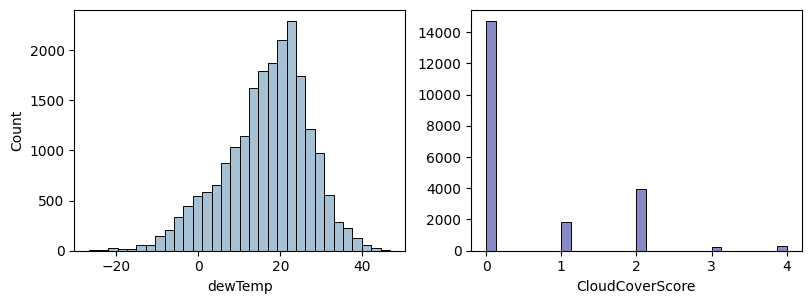

In [4]:
eda.numerical_distributions(df=data, features=['dewTemp', 'CloudCoverScore'])

Before running any experiments, we'll also run PCA on the weather features to see whether particular combinations of the weather features may be useful to predict the power. From the EDA, we can see that a couple of possible issues. 

- Outliers in wind speed, temperature and visibility
- Highly skewed distributions for visibility and cloud ceiling

Because of this, we'll leave out visibility initially, and experiment also with removing cloud ceiling for the same reason. I'll also try capping the outliers since they can have an undue influence on results. Note we've also left out pressure since this is a somewhat special case.

In [5]:
pca_features = ['Humidity', 'AmbientTemp', 'Wind.Speed']
data_pca = data[pca_features].copy()
data_pca.describe()

,Humidity,AmbientTemp,Wind.Speed
count,21045.000000,21045.000000,21045.000000
mean,37.121941,29.285117,16.620671
std,23.823011,12.366820,10.284960
min,0.000000,-19.981770,0.000000
25%,17.529300,21.915280,9.664756
50%,33.123780,30.289150,14.497135
75%,52.593990,37.474670,22.551098
max,99.987790,65.738370,78.928844


Differing scales and negative values so we'll use a standard scalar ahead of PCA, and also cap the outliers.

In [6]:
pipeline = Pipeline([
    
    ('capping', 
     Winsorizer(
         variables=["AmbientTemp", "Wind.Speed"],
         capping_method="iqr",
         tail="both",
         fold=1.5)),
    
    ('scaling', 
     StandardScaler())
])

X = pipeline.fit_transform(data_pca)

In [7]:
# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X)

base_loadings = pd.DataFrame(
    pca.components_.T,  
    columns=X_pca.columns, 
    index=X.columns, 
)
base_loadings

,pca0,pca1,pca2
Humidity,0.691889,-0.161916,-0.703614
AmbientTemp,-0.697166,0.103590,-0.709386
Wind.Speed,0.187749,0.981352,-0.041210


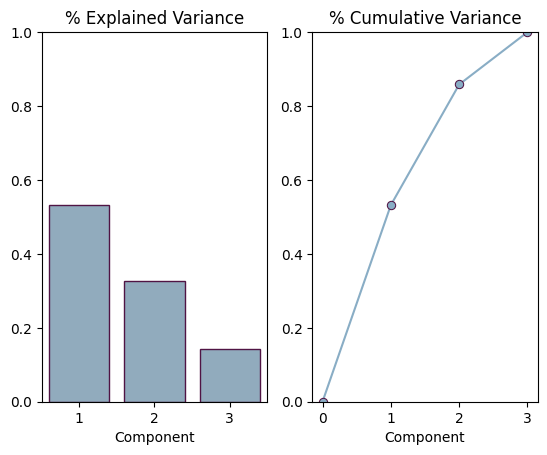

In [8]:
eda.plot_variance(pca)

Most of the variance is concentrated when temperature and humidity have opposite signs, and to a lesser extent when they take the same sign (as is the case in the dew temperature). The second component is interesting since it's dominated by the wind speed. We can look at the dependence of the target on the base features via the following plots. The strongest relationship appears to be between humidity and temperature, as implied by PCA, and it may be well modelled by a ratio of temperature to humidity. 

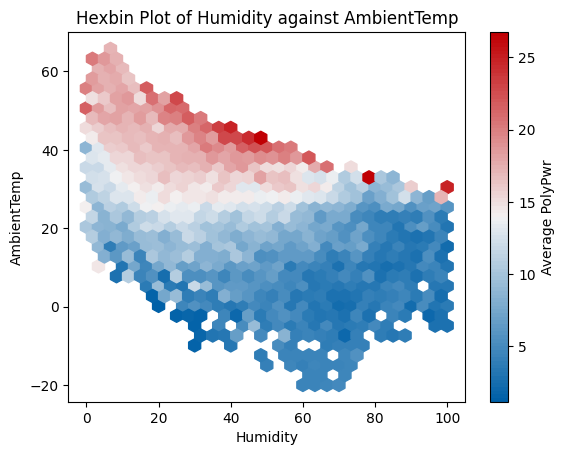

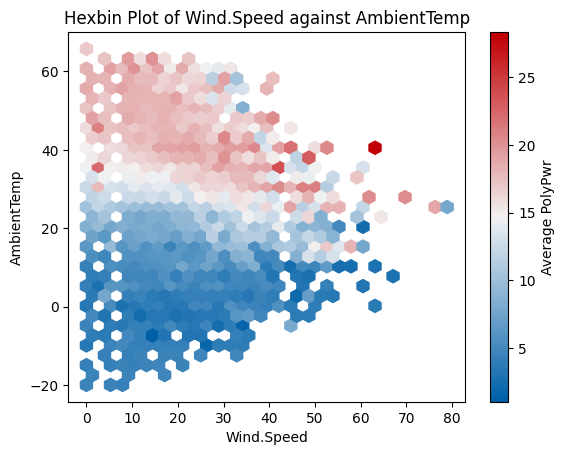

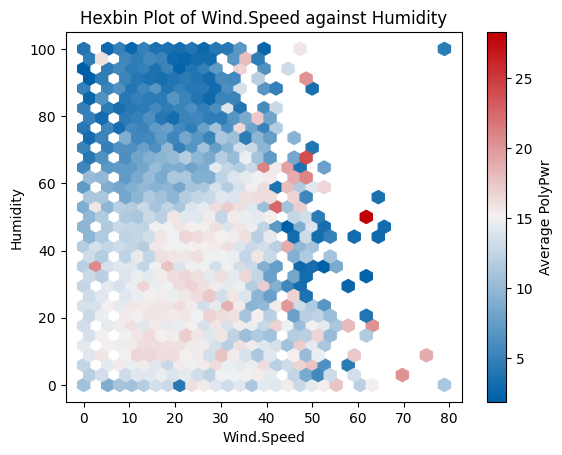

In [9]:
eda.hex_bin_plot(df=data, features=['Humidity', 'AmbientTemp'], target='PolyPwr')
eda.hex_bin_plot(df=data, features=['Wind.Speed', 'AmbientTemp'], target='PolyPwr')
eda.hex_bin_plot(df=data, features=['Wind.Speed', 'Humidity'], target='PolyPwr')

In [10]:
# We'll have np.inf where the humidity is zero, so we'll fill these values with the maximum seen in the rest of the series. 
data['TempDivHum'] = data['AmbientTemp'] / data['Humidity']
max_val = data['TempDivHum'].replace([np.inf, -np.inf], np.nan).dropna().max()
data['TempDivHum'] = data['TempDivHum'].replace([np.inf, -np.inf], np.nan).fillna(max_val)

In [11]:
data['PosTempNegHum'] = data['AmbientTemp'] - data['Humidity']

In [12]:
new_features = [col for col in data if col not in discrete + temporal + continuous + categorical + ['PolyPwr']]
new_features

['dewTemp', 'CloudCoverScore', 'TempDivHum', 'PosTempNegHum']

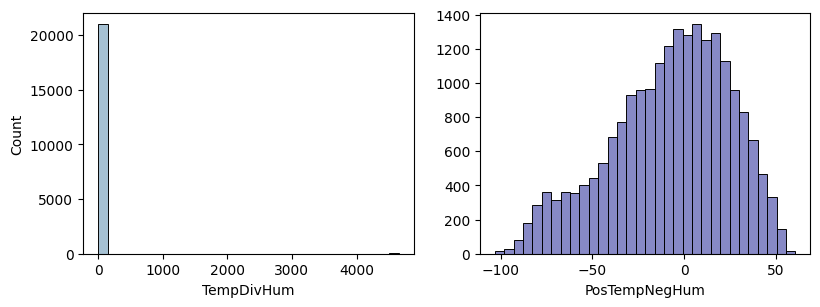

In [13]:
eda.numerical_distributions(df=data, features=['TempDivHum', 'PosTempNegHum'])

In [14]:
X = data[discrete + temporal + continuous + categorical + ['CloudCoverScore', 'TempDivHum']].copy()
X['Altitude'] = X['Altitude'].astype('O')
X['CloudCoverScore'] = X['CloudCoverScore'].astype('O')

y = data['PolyPwr'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X,  # predictors
    y,  # target
    train_size=0.8,  # percentage of obs in train set
    random_state=0)  # seed to ensure reproducibility

print(X_train.shape, X_test.shape)
print(X_train.columns)

(16836, 15) (4209, 15)
Index(['Latitude', 'Longitude', 'Altitude', 'month', 'hour', 'Humidity',
       'AmbientTemp', 'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling',
       'Location', 'Season', 'CloudCoverScore', 'TempDivHum'],
      dtype='object')


In [24]:
visibility_column_index = 19
cloud_ceiling_column_index = 21
temp_hum_ratio_column_index = 25

pipeline = Pipeline([
    
    ('rare_label_encoder', 
     ce.RareLabelEncoder(tol=0.05,
                         n_categories=4,
                         variables=['Location', 'CloudCoverScore'])),
    
    ('categorical_encoder',
     ce.OrdinalEncoder(encoding_method='ordered',
                       variables=['Season', 'Altitude'])),
    
    ('categorical_encoder_loc',
     ce.OrdinalEncoder(encoding_method='arbitrary',
                       variables=['Location', 'CloudCoverScore'])),
    
    ('rbf_month',
     RepeatingBasisFunction(remainder="passthrough",
                            n_periods=12,
                            column="month",
                            width=1.0,
                            input_range=(1,12))),
    
    ('binarizer_vis_cloudceil', 
     ColumnTransformer(transformers=[('binarize_vis', 
                                      Binarizer(threshold=15), 
                                      [visibility_column_index, cloud_ceiling_column_index])], 
                       remainder='passthrough')),
    
    ('binarizer_tempdivhum', 
     ColumnTransformer(transformers=[('binarize_tempdivhum', 
                                      Binarizer(threshold=4), 
                                      [temp_hum_ratio_column_index])], 
                       remainder='passthrough')),
    
    ('xgb', train.build_model())

])

scores = train.train_model(inputs=X_train, target=y_train, pipeline=pipeline)

Training on 5 folds
****************************************
R2 score on fold 1: 0.6557223447425344
R2 score on fold 2: 0.6687136271309955
R2 score on fold 3: 0.6730891736958902
R2 score on fold 4: 0.6716965653135456
R2 score on fold 5: 0.6470656835307017
****************************************


### Summary
While adding the linear combinations of temperature and humidity did nothing to improve the R2, using the cloud-cover score with rare grouping and arbitrary ordering along with a binarized ratio of temperature to humidity did improve things slightly. The new R2 is ~0.6633 with the following pipeline. 

In [16]:
pipeline

Pipeline(steps=[('rare_label_encoder',
                 RareLabelEncoder(n_categories=4,
                                  variables=['Location', 'CloudCoverScore'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['Season', 'Altitude'])),
                ('categorical_encoder_loc',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Location', 'CloudCoverScore'])),
                ('rbf_month',
                 RepeatingBasisFunction(column='month', i...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])